# Deep Learning for Computer Vision:  Assignment 3


## Computer Science: COMS W 4995 006


### Due: March 6, 2018

#### Problem

You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

a) Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

b) Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

c) Let the layer dimensions be parameters passed when the network is created.

d) Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

e) Build and run your network using your own constructs. The code for doing this might look like:

NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_decision_regions(NN)

f) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

g) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

h) Now replace your ReLU activation function with a softplus function and repeat.

Grading: a-g=90%, h=10%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

x1        x2    y
0  1.320439  1.559535  1.0
1 -1.086511  0.435300  0.0
2 -0.019128 -1.018980  2.0
3 -1.387026 -0.337759  1.0
4 -1.651410  1.006738  0.0

Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

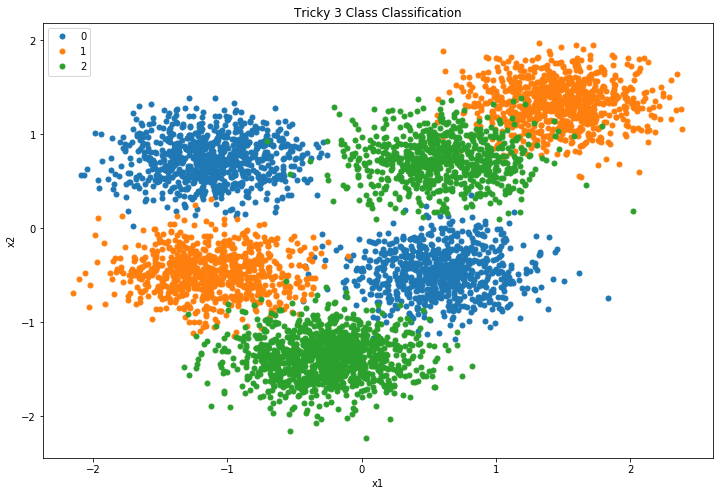

In [5]:
plot_data(X, y)

In [6]:
## I will use np.array type throughout the assignemnt
## because np.matrix type is hard to reshape into one dim
X = np.array(X)
y = np.array(y, dtype = np.int64)

Now build your network. Good luck! 😉 

a) Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

In [7]:
class Hidden:
    
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = np.random.randn(out_dim, in_dim) / np.sqrt(in_dim)
        self.b = np.zeros([out_dim, 1])
    
    def forward(self, X):
        self.X = X
        self.Z = np.dot(self.X, self.W.T) + self.b.reshape(-1)
        self.h = np.maximum(0, self.Z)
        return self.h
    
    def backward(self, d_in):
        self.h[self.h > 0] = 1
        dZ = self.h * d_in
        dW = dZ.T.dot(self.X)
        db = dZ      
        dX = dZ.dot(self.W)
        return dW, db, dX

In [8]:
class Output:
    
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = np.random.randn(out_dim, in_dim) / np.sqrt(in_dim)
        self.b = np.zeros([out_dim, 1])
    
    def forward(self, X):
        self.X = X
        self.Z = np.dot(self.X, self.W.T) + self.b.reshape(-1)
        return self.Z
        
    def backward(self, d_in):
        dW = d_in.T.dot(self.X)
        db = d_in      
        dX = d_in.dot(self.W)
        return dW, db, dX

In [9]:
class Loss:
    
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
    
    def forward(self, Z, y_batch, status = "train"):
        self.y_batch = y_batch
        N = Z.shape[0]
        # softmax function
        # minus the maximum value to avoid overflow
        self.probs = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
        self.probs /= np.sum(self.probs, axis = 1, keepdims = True)
        if status == "test":
            return self.probs
        loss = -np.sum(np.log(self.probs[np.arange(N), self.y_batch.reshape(-1)])) / N
        return self.probs, loss
    
    def backward(self, y_batch):
        N = self.probs.shape[0]
        dZ = self.probs.copy()
        dZ[np.arange(N), y_batch.reshape(-1)] -= 1
        return dZ

b) Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

c) Let the layer dimensions be parameters passed when the network is created.

d) Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

In [10]:
class MLP:
    
    def __init__(self):
        self.layer = []
    
    def add_layer(self, layer_type, in_dim, out_dim):
        if layer_type == "Hidden": 
            self.layer.append(Hidden(in_dim, out_dim))
        elif layer_type == "Output":
            self.layer.append(Output(in_dim, out_dim))
        elif layer_type == "Loss":
            self.layer.append(Loss(in_dim, out_dim))
        else:
            print ("wrong argument")
            exit(1);
    
    def forward_propagation(self, X_batch, y_batch, alpha, status = "train"):
        A = X_batch
        for idx, layer in enumerate(self.layer):
            if (idx != len(self.layer) - 1):
                A = layer.forward(A)
        if alpha > 0 and status == "train":
            probs, loss = self.layer[len(self.layer) - 1].forward(A, y_batch, status)
            # add the regulation loss
            for idx, layer in enumerate(self.layer):
                if (idx != len(self.layer) - 1):
                    loss += 0.5 * alpha * np.sum(np.power(layer.W, 2))
            return probs, loss
        ## last layer is the loss layer
        return self.layer[len(self.layer) - 1].forward(A, y_batch, status)
            
    
    def backward_propagation(self, alpha, y_batch):
        l = len(self.layer)
        gradients = {}
        dZ = self.layer[l - 1].backward(y_batch);
        for idx in range(l - 2, -1, -1):
            dW, db, dZ = self.layer[idx].backward(dZ)
            gradients[(idx, "W")] = dW
            gradients[(idx, "b")] = db
            if alpha > 0:
                gradients[(idx, "W")] += alpha * self.layer[idx].W
            
        return gradients
            
    
    def train(self, X, y, max_epochs, batch_size, eta = 0.1, alpha = 0.0):
        
        def get_batch(batch_size = 16):
            indicies = np.arange(X.shape[0])
            for i in range(int(np.ceil(X.shape[0] / batch_size))):
                start_idx = (i * batch_size) % X.shape[0]
                idx = indicies[start_idx:start_idx + batch_size]
                yield X[idx, :], y[idx]
            
        # I define the loss as epoch loss
        loss = []
        for t in range(max_epochs):
            tmp_loss = []
            for X_batch, y_batch in get_batch():    
                probs, loss_ = self.forward_propagation(X_batch, y_batch, alpha)
                gradients = self.backward_propagation(alpha, y_batch)
                tmp_loss.append(loss_)
                ## update parameter
                for idx in range(len(self.layer) - 1):
                    self.layer[idx].W -= 1.0/batch_size * eta * gradients[(idx, "W")]
                    self.layer[idx].b -= 1.0/batch_size * eta  \
                                        * np.sum(gradients[(idx, "b")], axis = 0).reshape(self.layer[idx].b.shape)
            loss.append(sum(tmp_loss) / len(tmp_loss))
                
        return loss
        
        
    def predict(self, X_test, alpha = 0):
        probs = self.forward_propagation(X_test, None, alpha, status = "test")
        y_predict = np.argmax(probs, axis = 1)
        return y_predict

e) Build and run your network using your own constructs. <br>
f) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

In [11]:
# since the question don't specify batch loss or epoch loss
# I assume to be epoch loss, which is the mean of all batch loss in an epoch
def plot_loss(loss, alpha = 0, num_hidden_units = 16, num_hidden_layers = 3):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title('loss for alpha = %.2f,num_hidden_units = %d, num_hidden_layers = %d'% \
              (alpha, num_hidden_units, num_hidden_layers))
    ax.plot(loss)    
    plt.show()

In [12]:
def plot_decision_regions(NN, alpha = 0, num_hidden_units = 16, num_hidden_layers = 3):
    X_test = np.random.uniform(-3, 3, (10000,2))
    y_pred = NN.predict(X_test)
    X_test0 = X_test[y_pred == 0]
    X_test1 = X_test[y_pred == 1]
    X_test2 = X_test[y_pred == 2]
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(X_test0[:,0], X_test0[:,1], 'o', label='0')
    ax.plot(X_test1[:,0], X_test1[:,1], 'o', label='1')
    ax.plot(X_test2[:,0], X_test2[:,1], 'o', label='2')
    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('decision region for alpha = %.2f,num_hidden_units = %d, num_hidden_layers = %d'% \
                  (alpha, num_hidden_units, num_hidden_layers))
    plt.show()

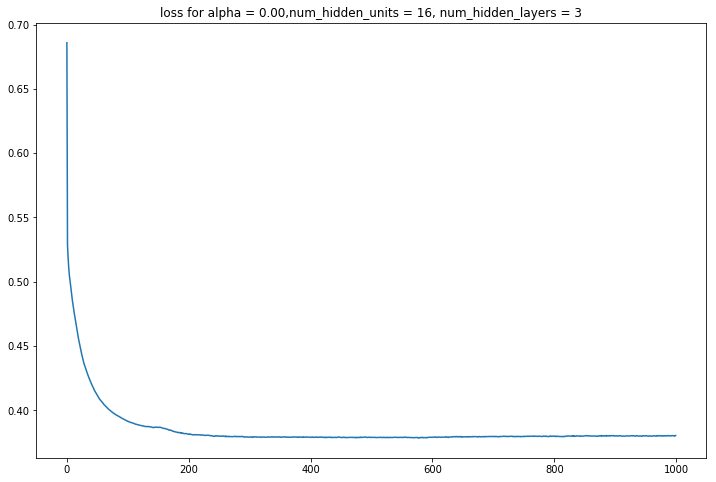

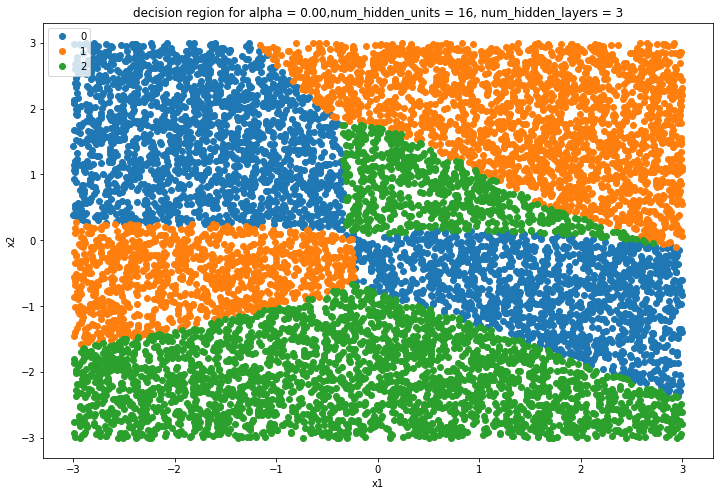

In [14]:
# Note, I plot the epoch loss(insead of the batch loss, 
# so the loss figure is not fluctuate as others)
NN = MLP()
NN.add_layer('Hidden', in_dim=2, out_dim=16)
NN.add_layer('Hidden', in_dim=16, out_dim=16)
NN.add_layer('Hidden', in_dim=16, out_dim=16)
NN.add_layer('Output', in_dim=16, out_dim=3)
NN.add_layer('Loss', in_dim=3, out_dim=3)
loss = NN.train(X, y, max_epochs=1000, batch_size=16, alpha=0.01, eta = 0.1)
plot_loss(loss)
plot_decision_regions(NN)

g) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

In the below output, two consecutive figure consists of a seperate case with loss funciton and decision boundary. You can see their set up(I mean parameter) in the title of the figure.

From the hint given by TA on slack, I write the observation as follows:
- First as it's not point out whether batch loss or epoch loss is required. I plot epoch loss, which avergaes all batch loss in one epoch, so the figure is not as fluctuated as batch loss.
- I use parameter alpha(0, 0.01), learning rate = 0.1 to let it run faster
- but it cause problem with simple network(one hidden layer) and alpha(0.01) (you can see in the figure below the loss first go down and then go up). this can be avoid by tunning the parametrs (more small alpha and learning rate is adorable for such situation). BUT in practice, we don't add regularization to simple network, so I keep it as what it's like.

Observation:
- For the same alpha (I implement L2 regu), num_hidden_units and different num_hidden_layers, I observe the network becomes better at classfying the points when the hidden layer increases (less loss and better boundary in classification).
- For the same alpha (I implement L2 regu), num_hidden_layers and different num_hidden_layers, I observe the network becomes better at classfying the points when the hidden units increases (less loss and better boundary in classification).
- For the same num_hidden_layers, num_hidden_layers and different alpha(I implement L2 regu). I can observe the classifier with regularization has more simple boundaries. In theory, this will be better applied to test dataset.
- One interesting observation is that when the network is simple (only one hidden layer) and the regularization parameter is a little big(0.01),(such case happend with num_hidden_units = 3, 8, 16, num_hidden_layers = 1, alpha = 0.01) the loss go up. This is because the W add much in the loss function. It can be avoided by setting more small learning rate (and more small alpha), but I keep to use a little bigger rate across 12 combinations since it add to the speed of training in my MAC.

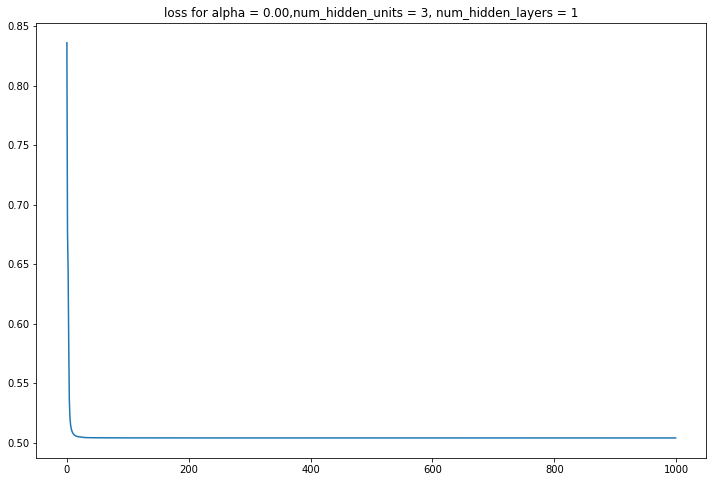

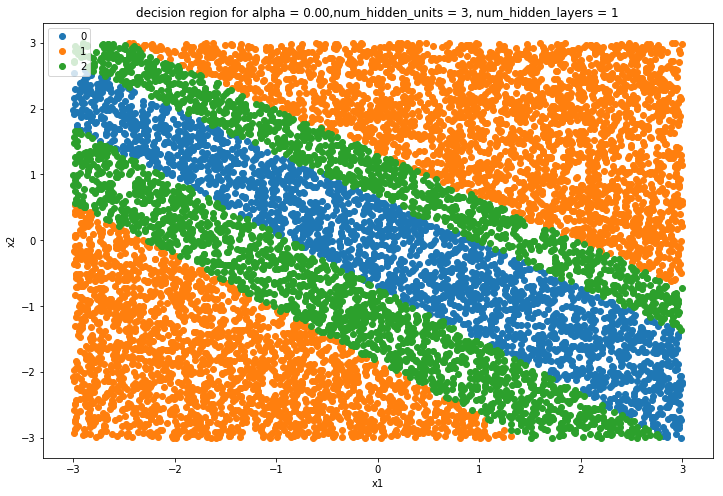

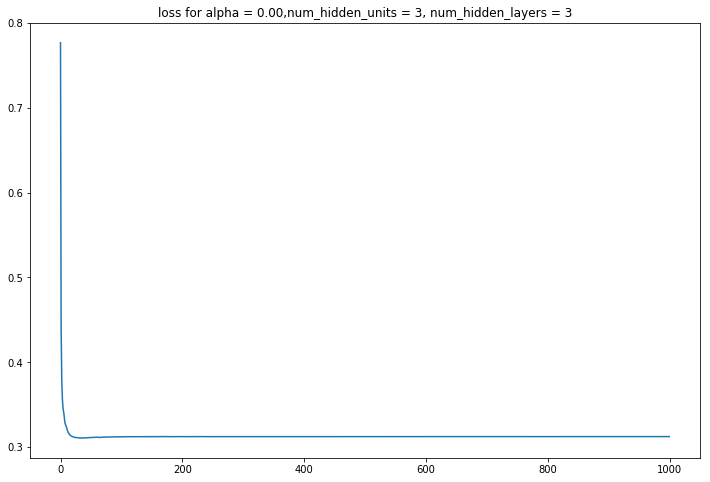

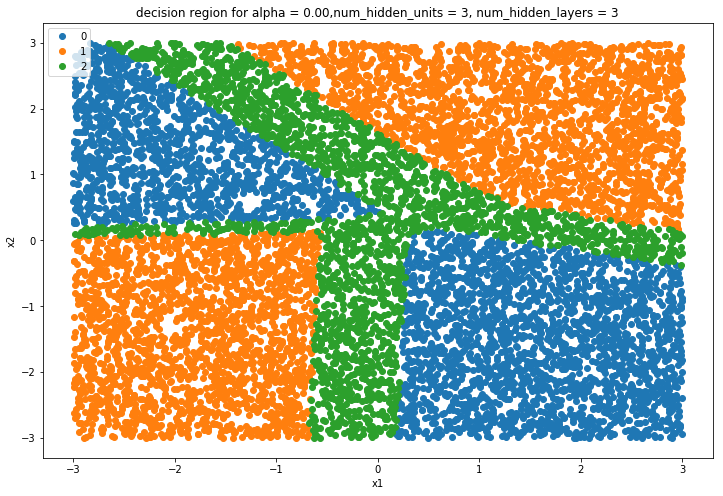

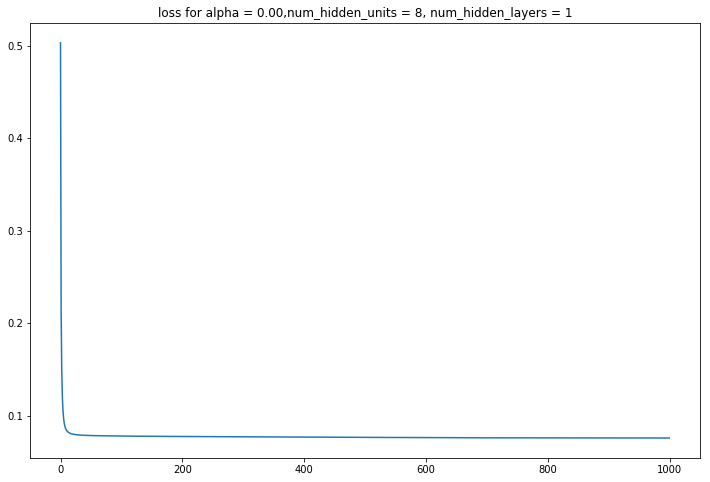

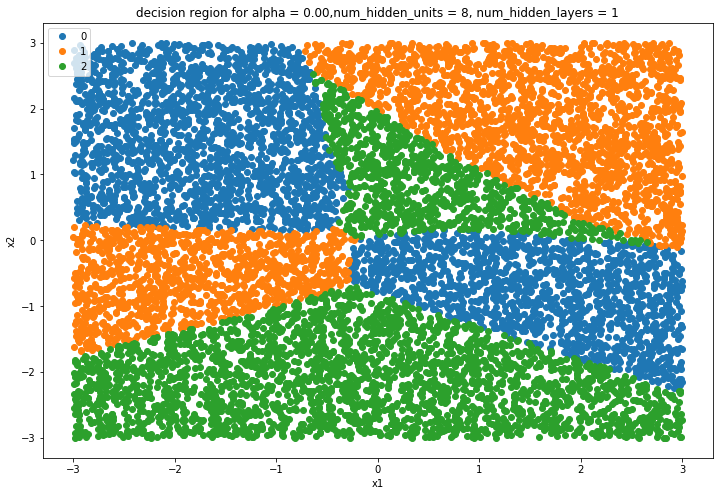

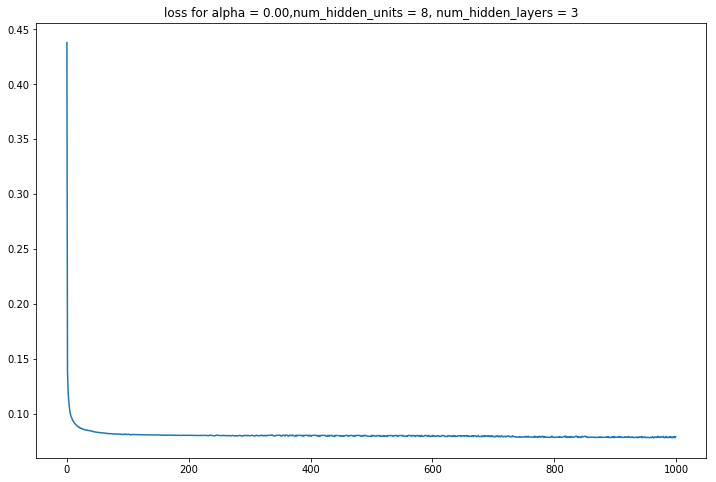

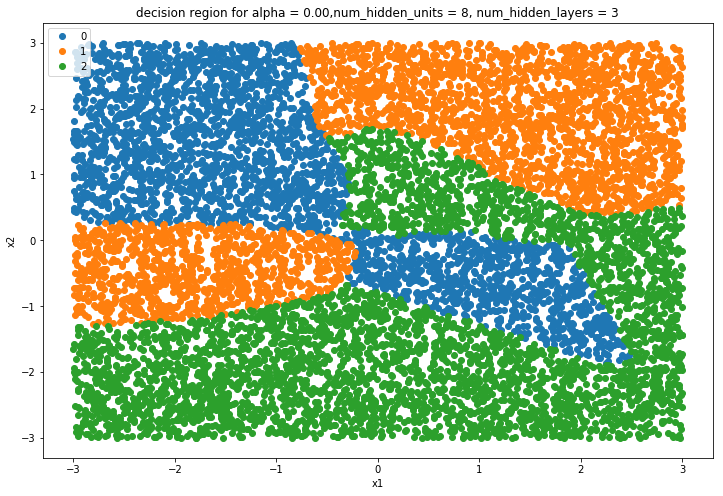

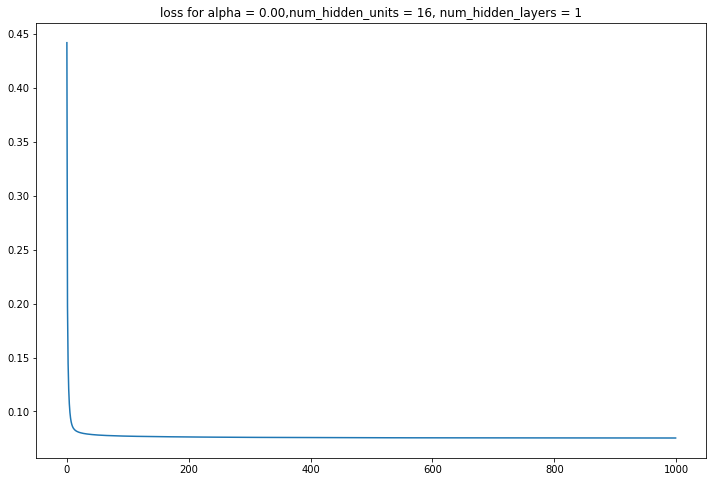

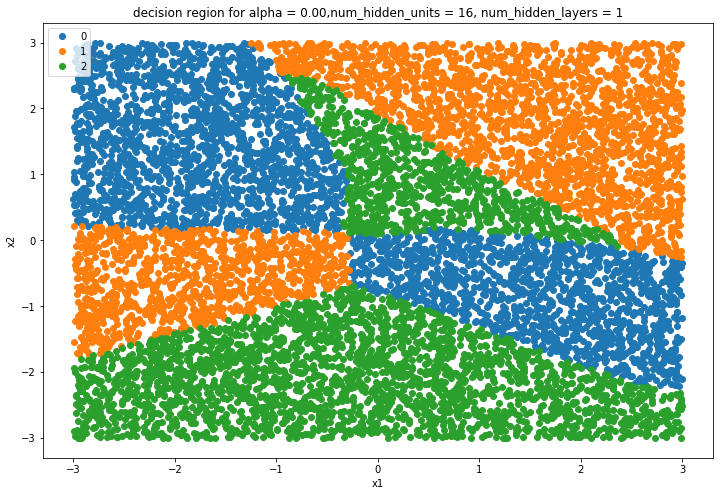

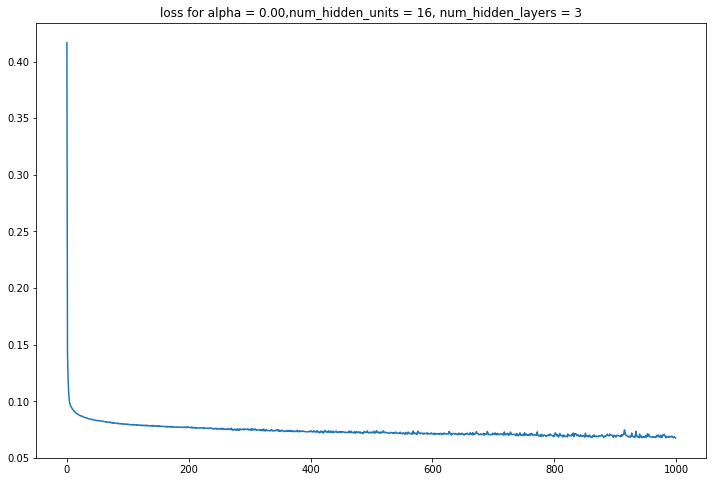

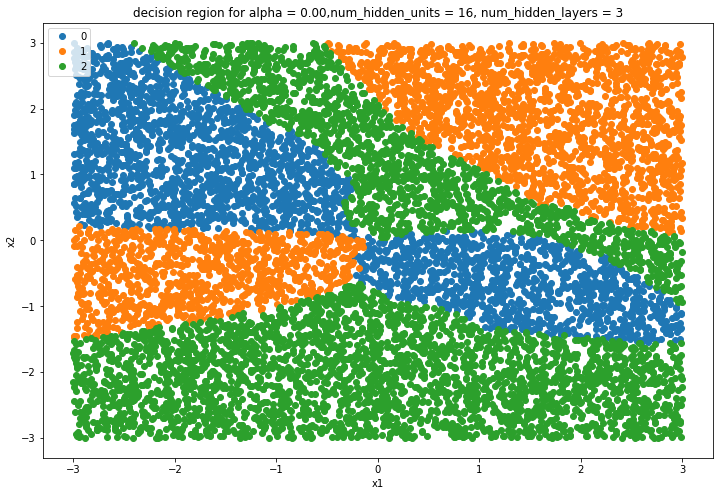

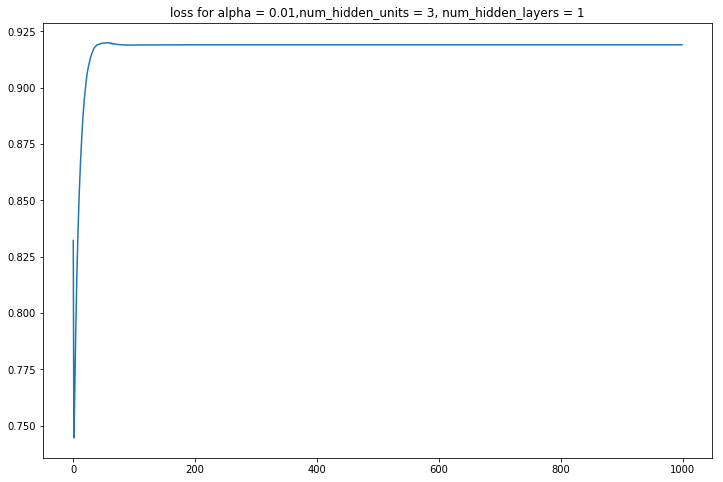

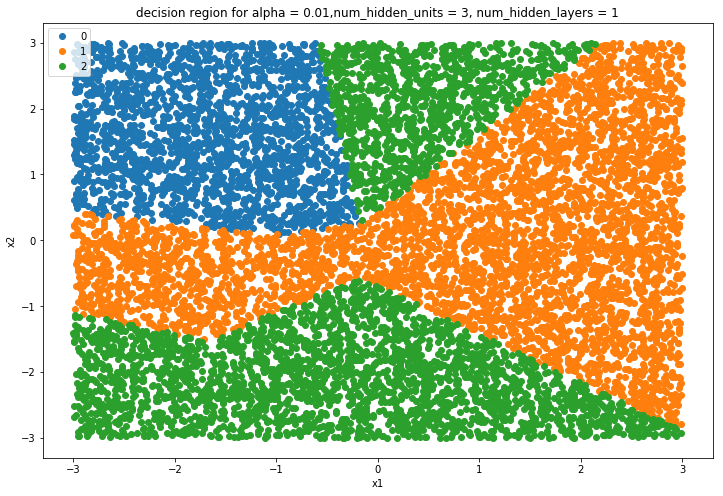

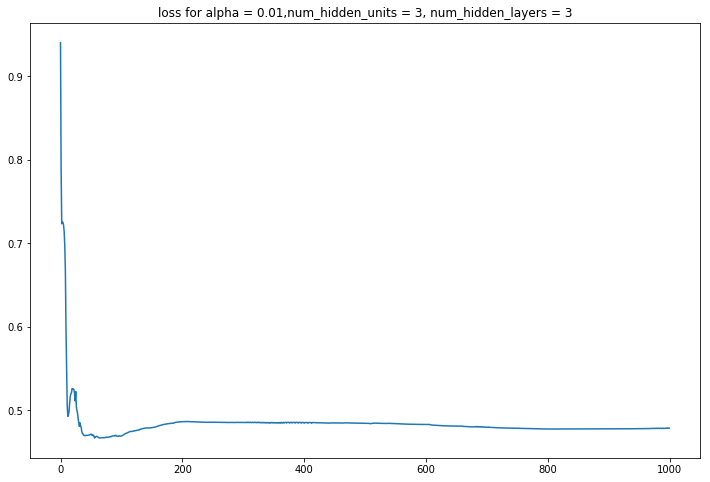

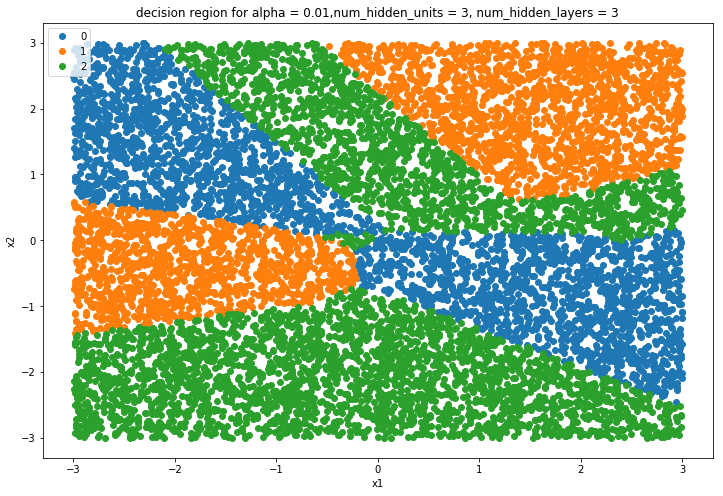

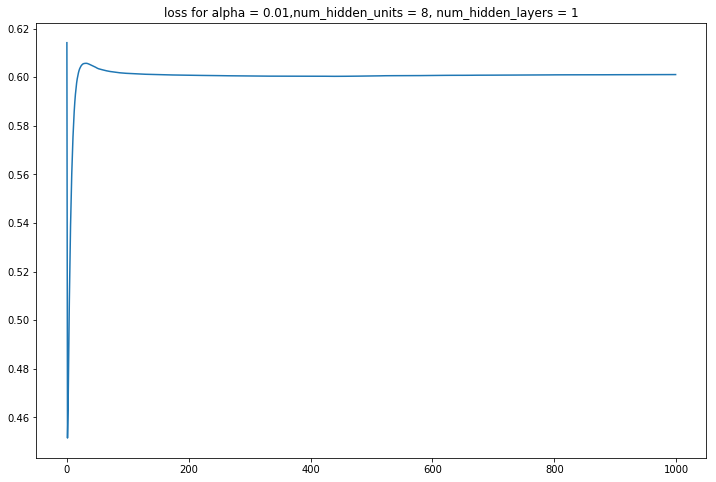

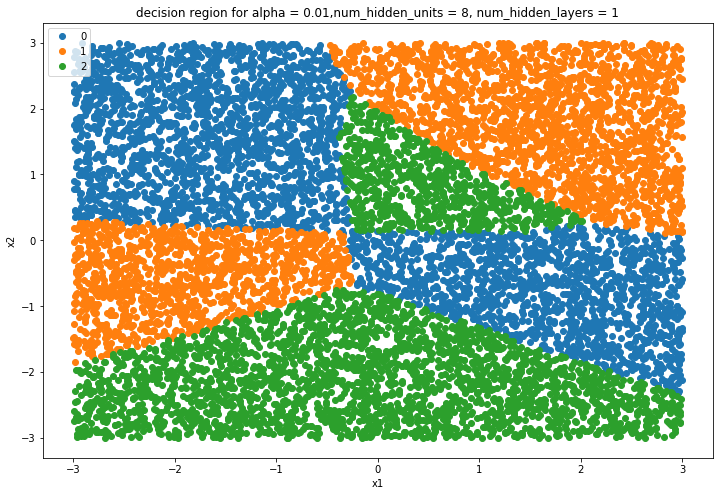

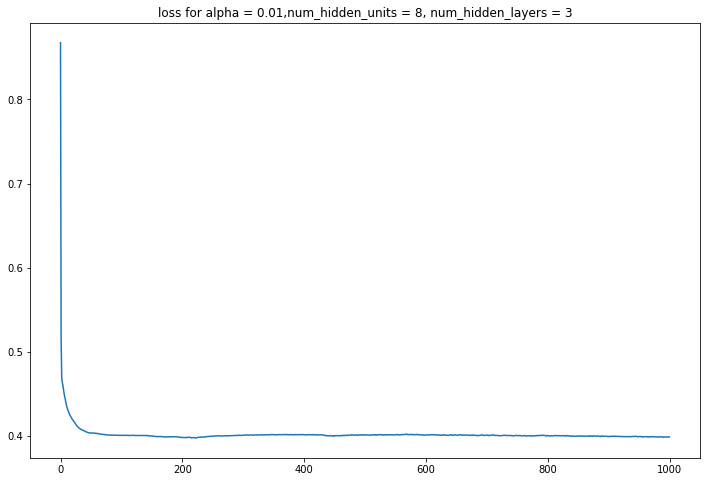

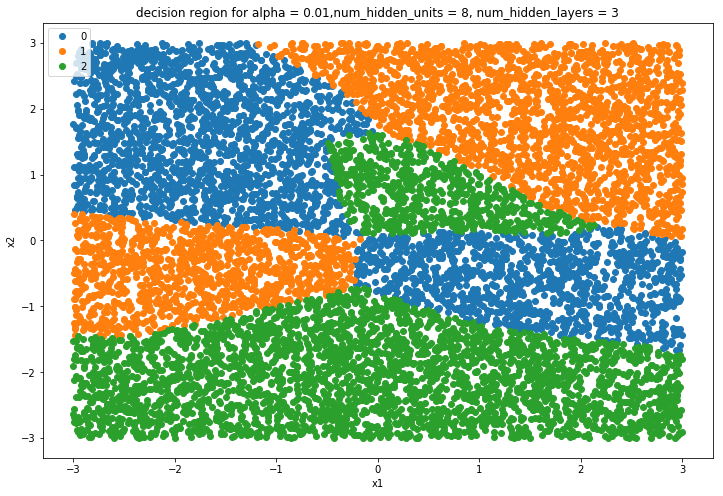

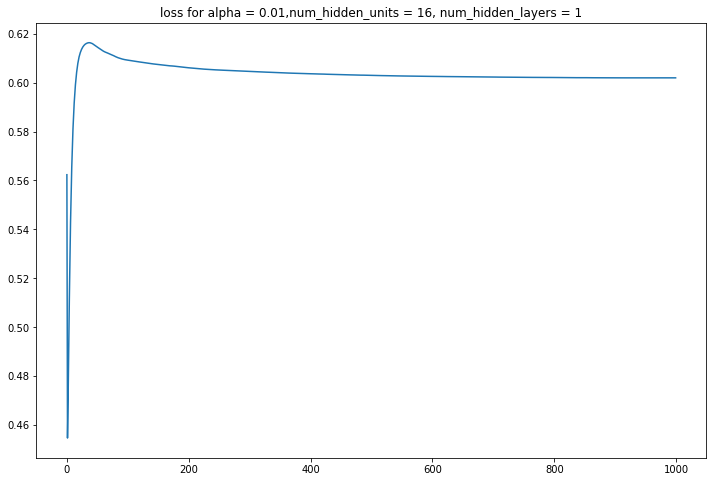

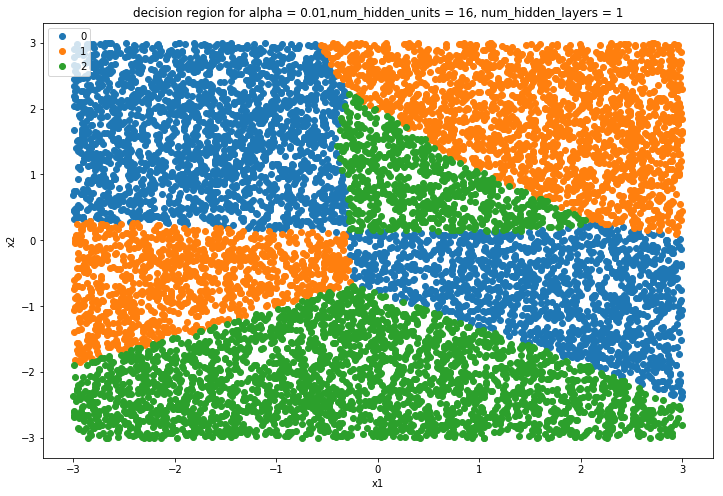

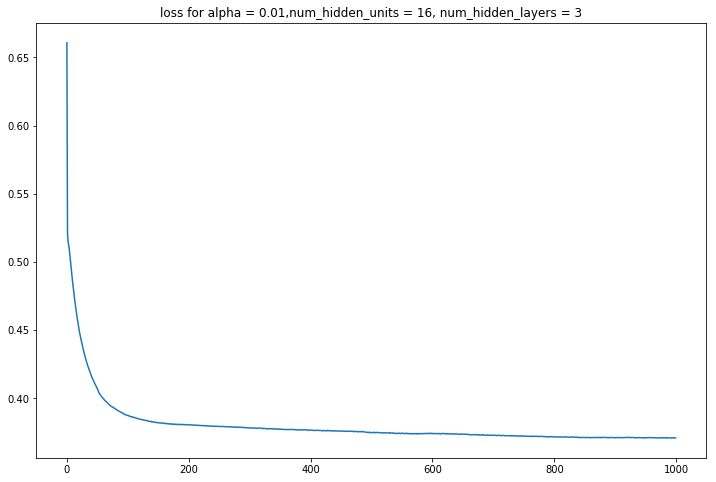

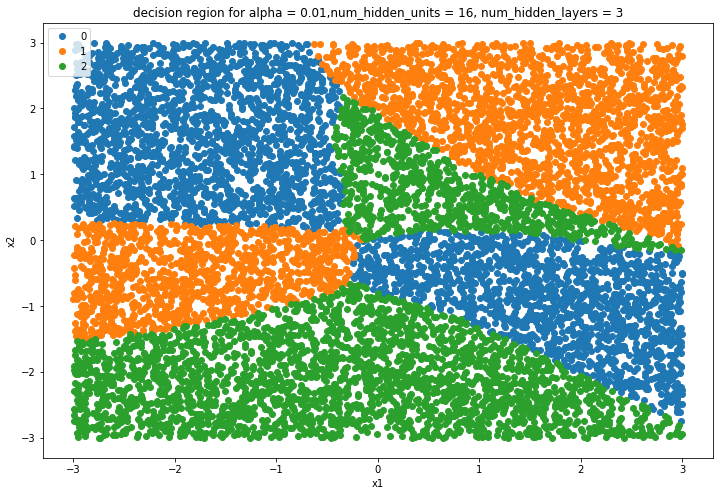

In [15]:
for alpha in [0, 0.01]:
    for num_hidden_units in [3, 8, 16]:
        for num_hidden_layers in [1,3]:
            NN = MLP()
            NN.add_layer('Hidden', in_dim=2, out_dim=num_hidden_units)
            for i in range(num_hidden_layers - 1):
                NN.add_layer('Hidden', in_dim=num_hidden_units, out_dim=num_hidden_units)
            NN.add_layer('Output', in_dim=num_hidden_units, out_dim=3)
            NN.add_layer('Loss', in_dim=3, out_dim=3)
            loss = NN.train(X, y, max_epochs=1000, batch_size=16, alpha=alpha)
            plot_loss(loss, alpha, num_hidden_units, num_hidden_layers)
            plot_decision_regions(NN, alpha, num_hidden_units, num_hidden_layers)

h) Now replace your ReLU activation function with a softplus function and repeat.

- Same setup as Q(g) instead of change the loss function
- Relu is much like softplus except near 0 where the softplus is enticingly smooth and differentiable
- One clear observarion is that softplus takes more computational time than Relu

In [16]:
class Hidden:
    
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = np.random.randn(out_dim, in_dim) / np.sqrt(in_dim)
        self.b = np.zeros([out_dim, 1])
    
    def forward(self, X):
        self.X = X
        self.Z = np.dot(self.X, self.W.T) + self.b.reshape(-1)
        self.h = np.log(1 + np.exp(self.Z))
        return self.h
    
    def backward(self, d_in):
        dh = 1/(1 + np.exp(-self.Z))
        dZ = dh * d_in
        dW = dZ.T.dot(self.X)
        db = dZ      
        dX = dZ.dot(self.W)
        return dW, db, dX

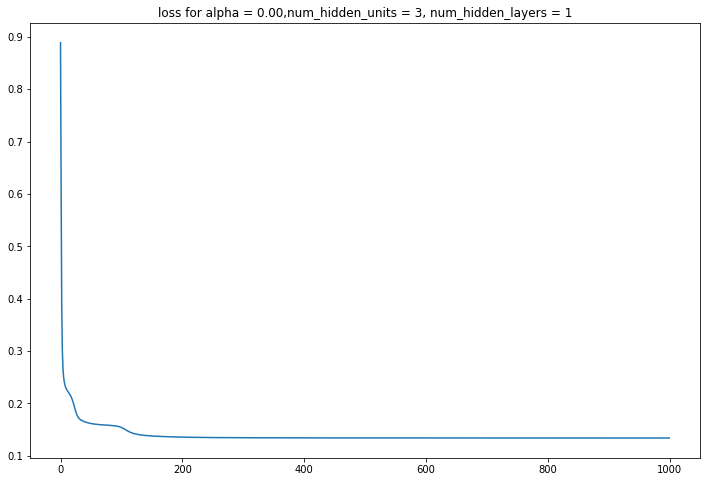

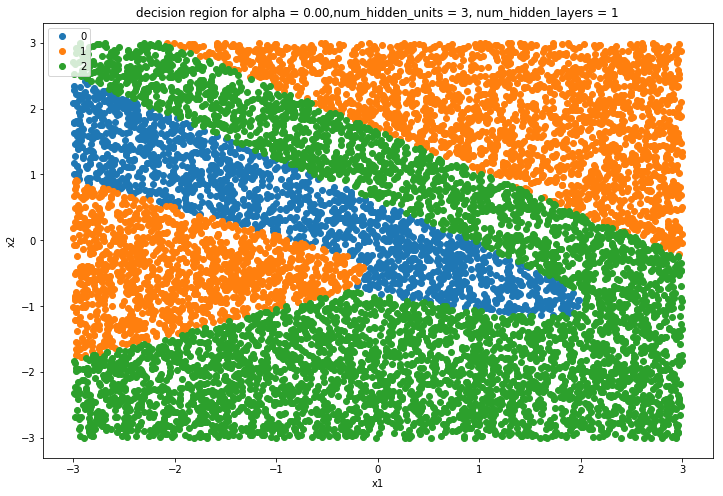

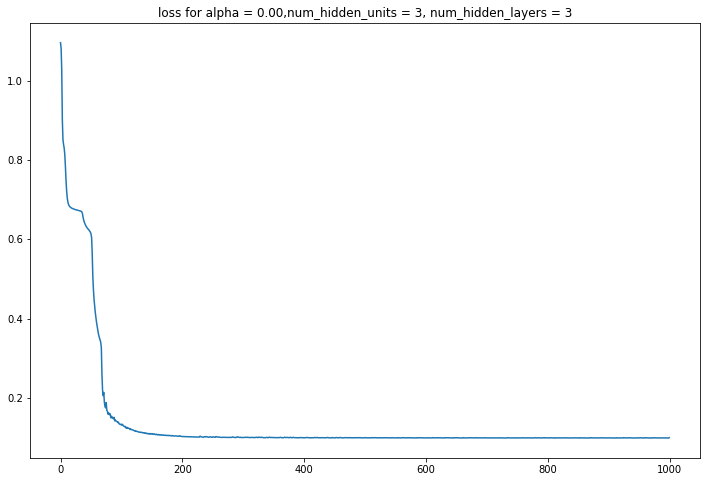

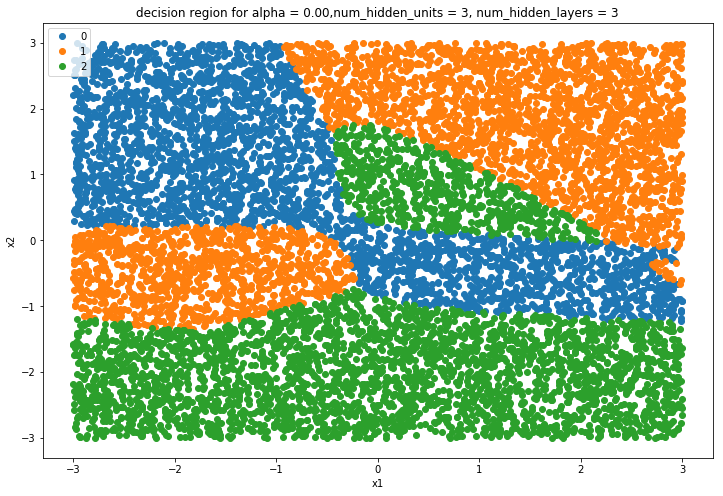

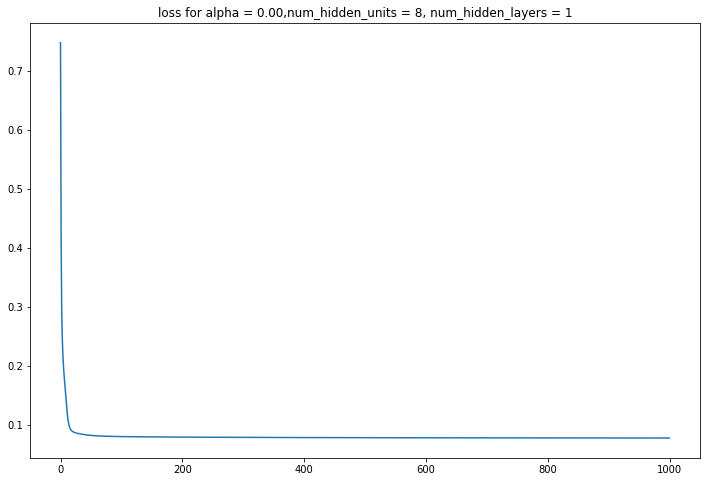

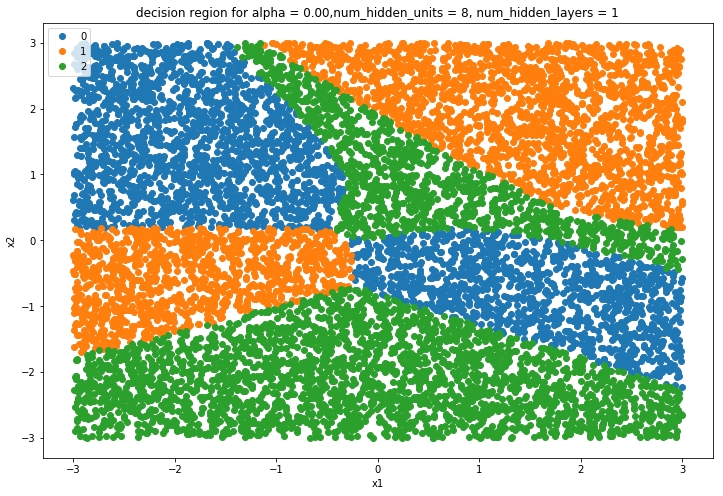

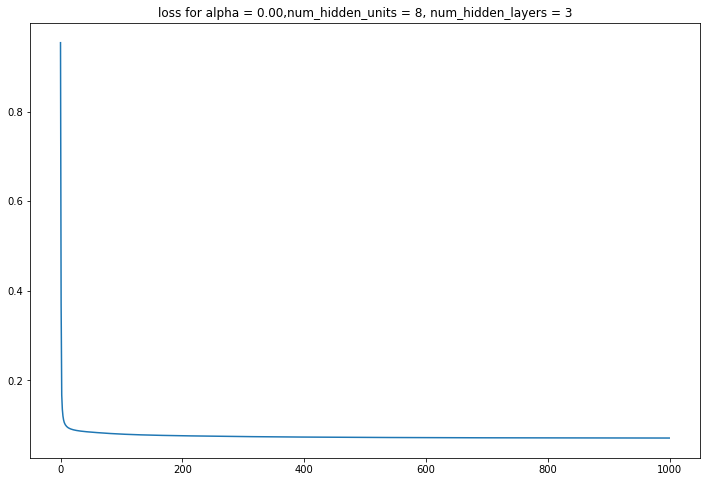

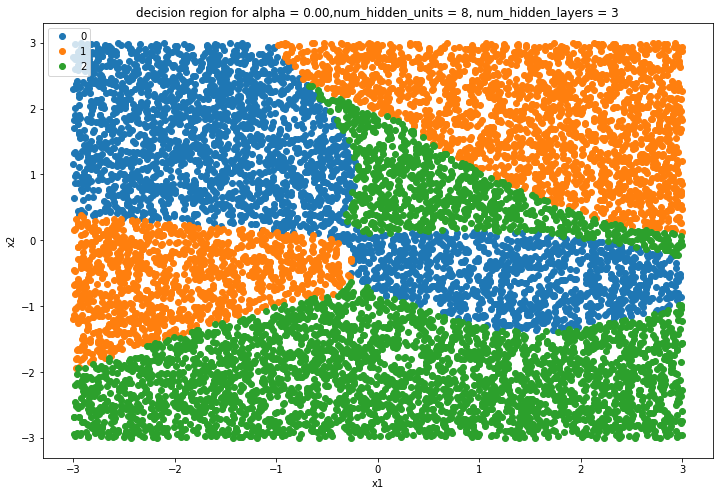

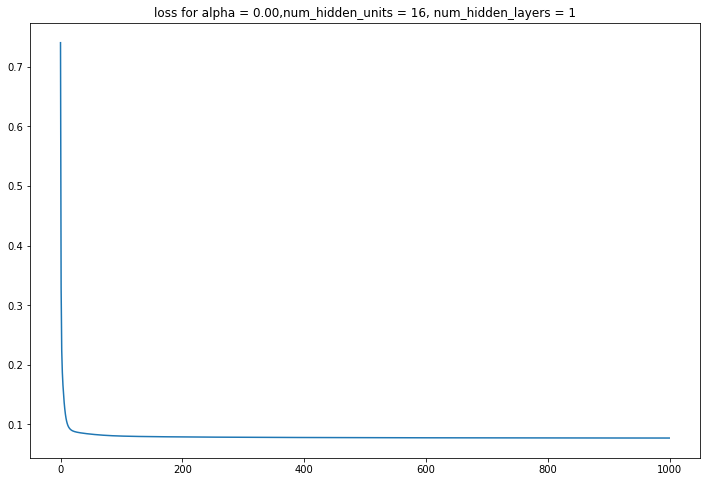

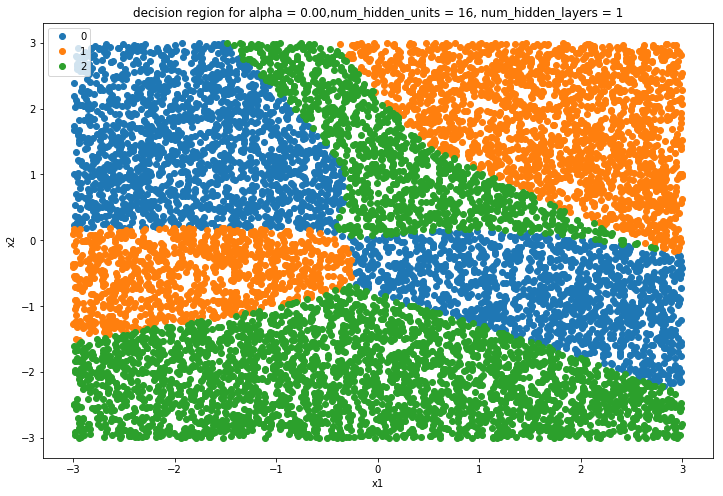

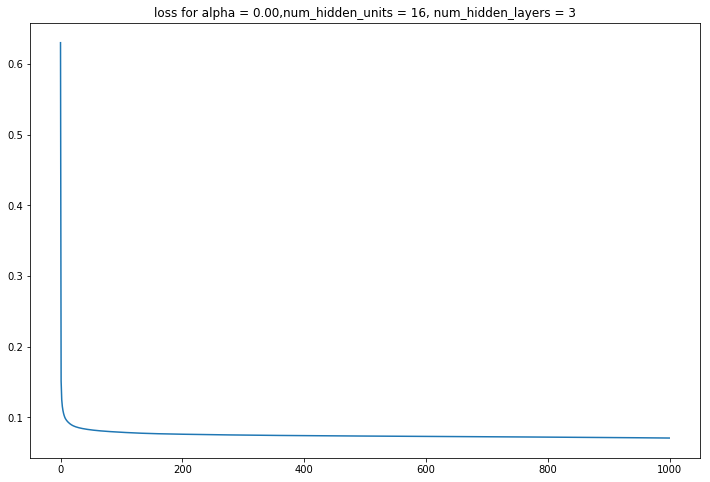

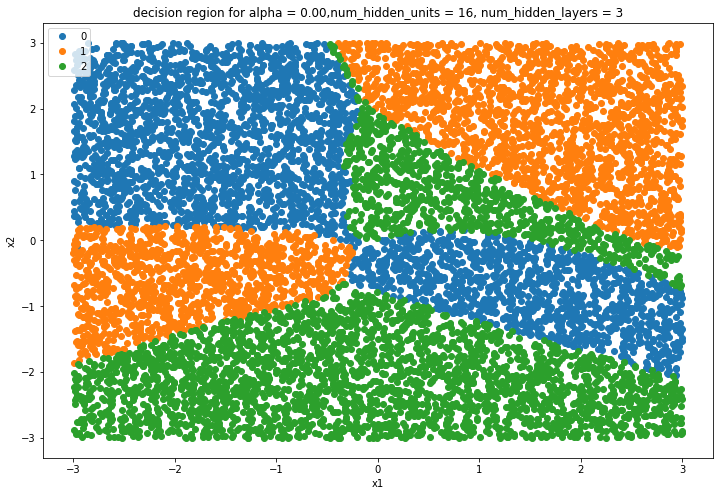

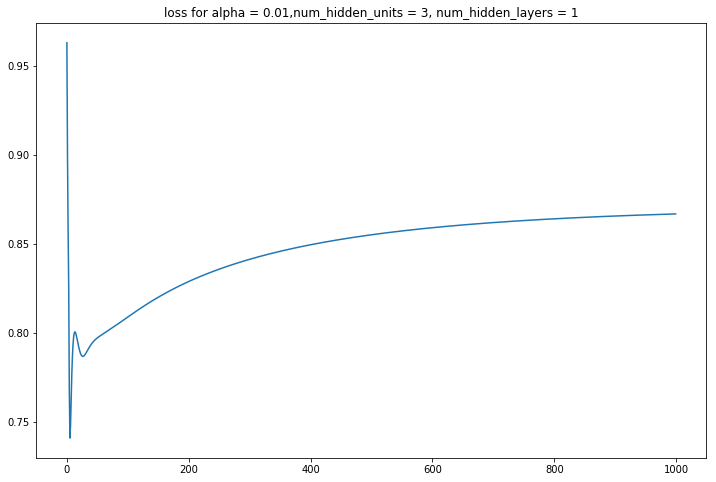

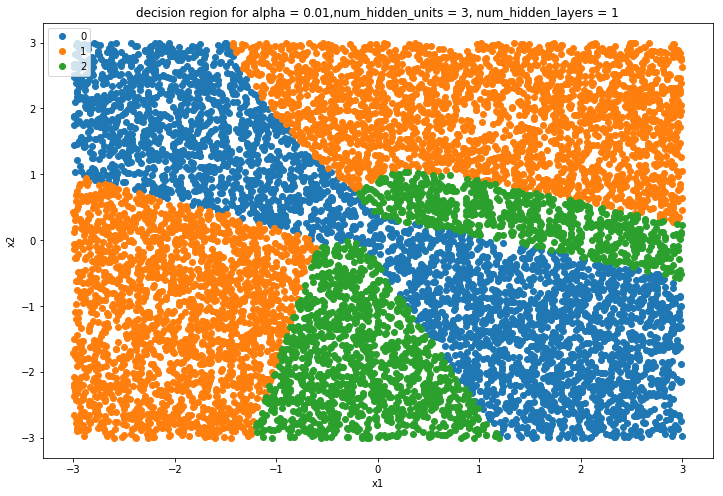

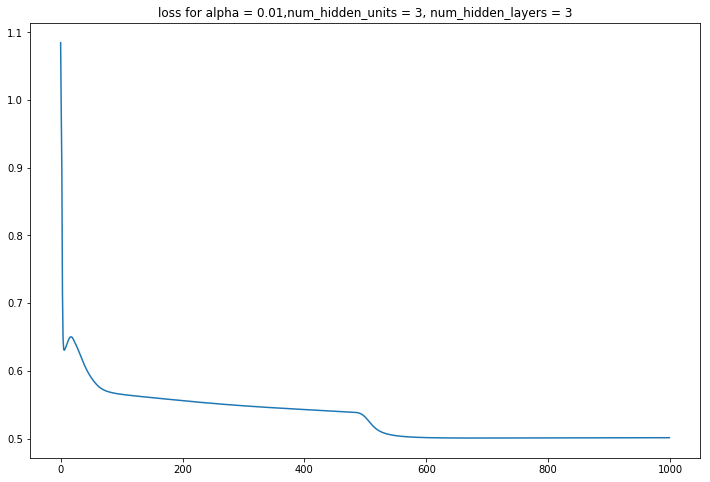

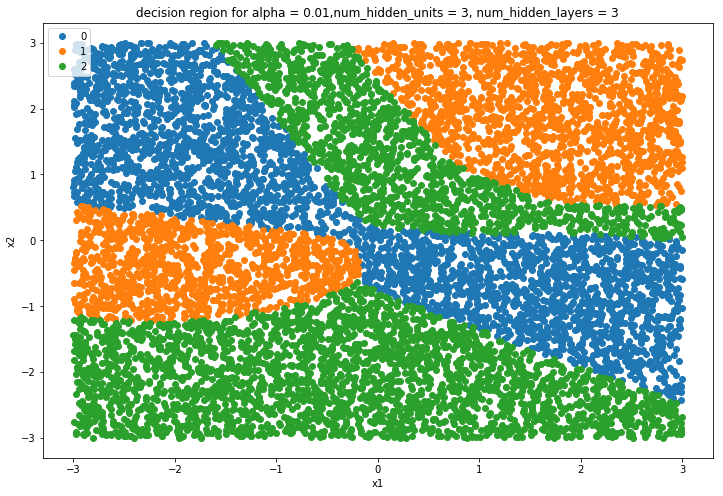

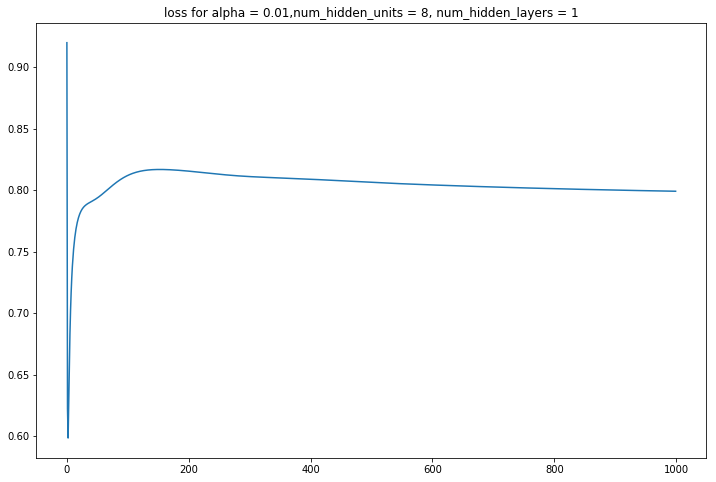

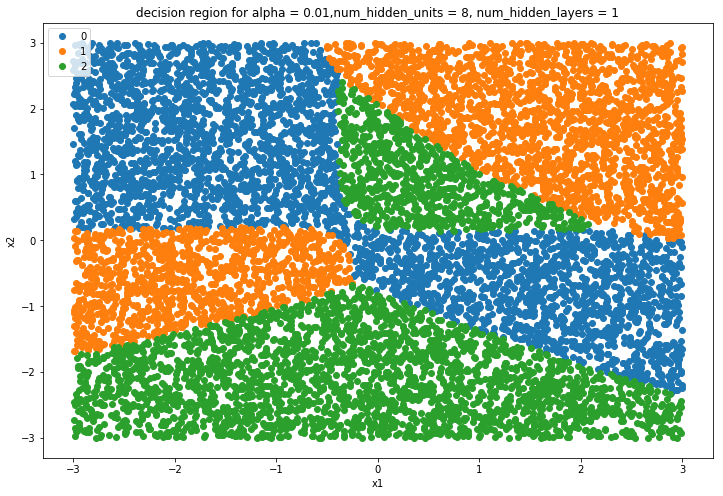

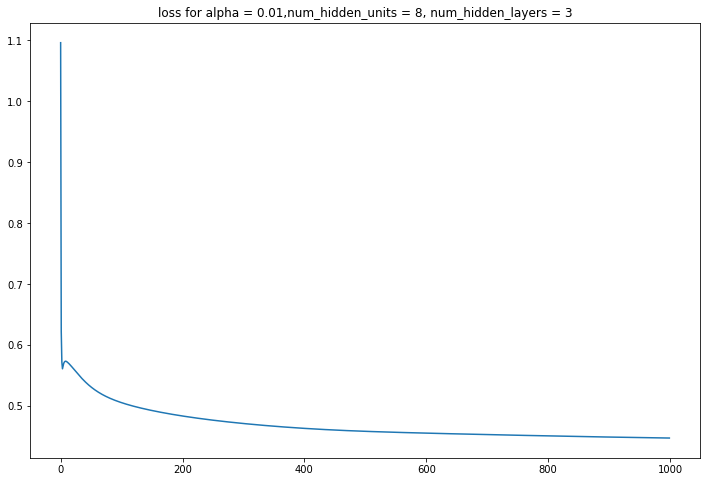

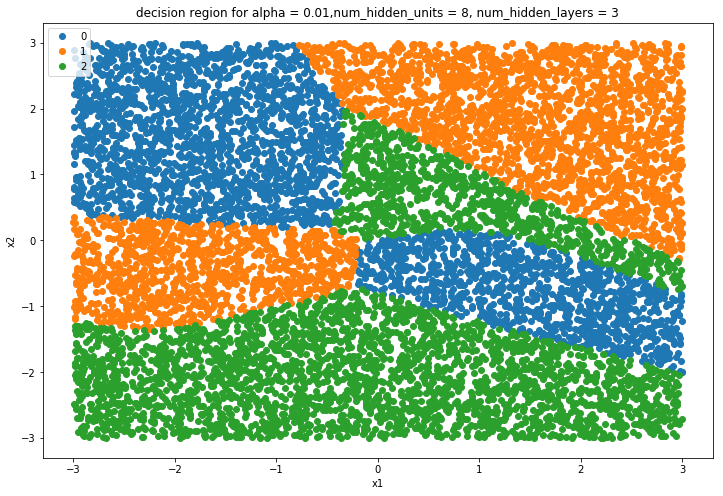

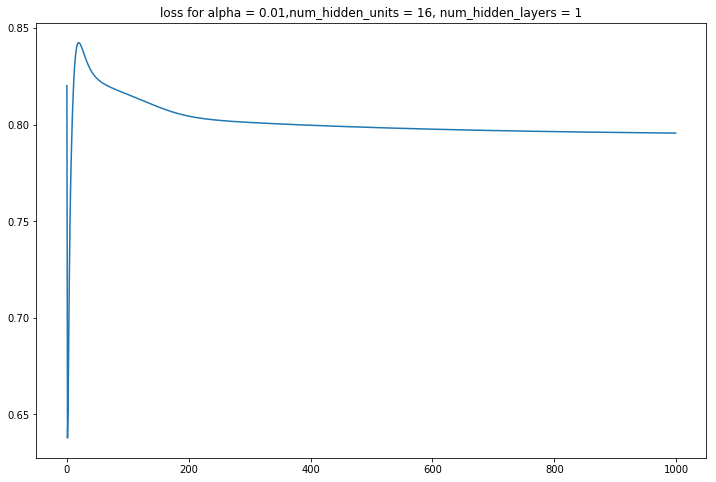

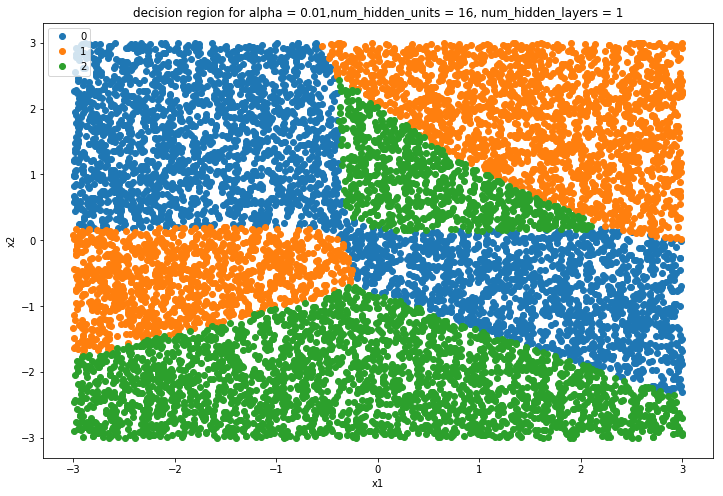

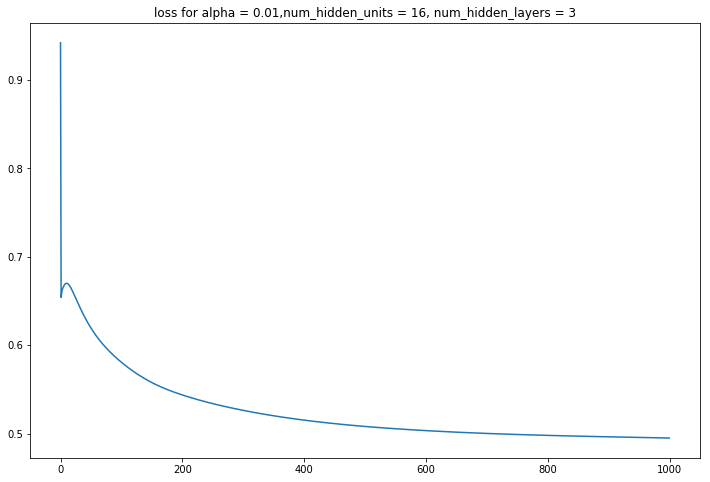

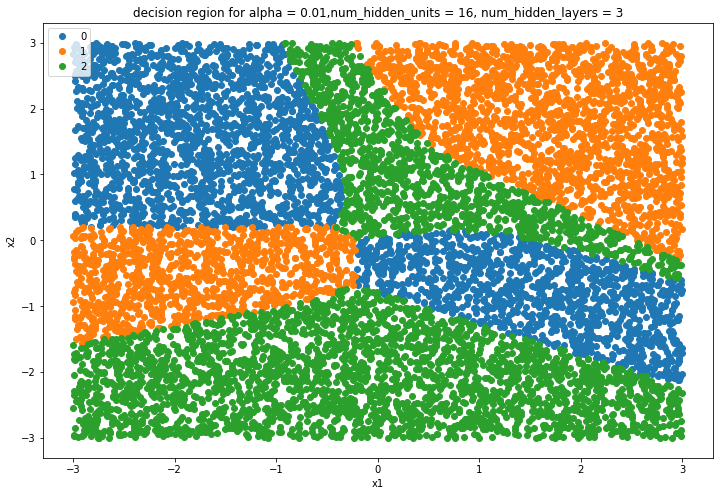

In [17]:
for alpha in [0, 0.01]:
    for num_hidden_units in [3, 8, 16]:
        for num_hidden_layers in [1,3]:
            NN = MLP()
            NN.add_layer('Hidden', in_dim=2, out_dim=num_hidden_units)
            for i in range(num_hidden_layers - 1):
                NN.add_layer('Hidden', in_dim=num_hidden_units, out_dim=num_hidden_units)
            NN.add_layer('Output', in_dim=num_hidden_units, out_dim=3)
            NN.add_layer('Loss', in_dim=3, out_dim=3)
            loss = NN.train(X, y, max_epochs=1000, batch_size=16, alpha=alpha)
            plot_loss(loss, alpha, num_hidden_units, num_hidden_layers)
            plot_decision_regions(NN, alpha, num_hidden_units, num_hidden_layers)